<a href="https://colab.research.google.com/github/silentfortin/ai-portfolio/blob/main/06-dl-pytorch-food/food_image_classification_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import requests
import zipfile
import io

import torch
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [2]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(f'Using this device: {device}')

Using this device: cuda


In [3]:
url = "https://proai-datasets.s3.eu-west-3.amazonaws.com/dataset_food_classification.zip"

response = requests.get(url)
response.raise_for_status()

zip_file = zipfile.ZipFile(io.BytesIO(response.content))

zip_file.extractall("/content/")


In [4]:
# Define the training data transformation
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


train_dataset = ImageFolder(root='/content/dataset/train', transform=train_transform)
val_dataset = ImageFolder(root='/content/dataset/val', transform=val_test_transform)
test_dataset = ImageFolder(root='/content/dataset/test', transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Train samples: {len(train_dataset)}')
print(f'Valid samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')

Train samples: 8960
Valid samples: 2240
Test samples: 2800


In [5]:
# è bilanciato? pare di si

from collections import Counter
import os

def count_images_per_class(folder_path):
    counts = {}
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            counts[class_name] = len(os.listdir(class_folder))
    return counts

train_counts = count_images_per_class('/content/dataset/train')
val_counts = count_images_per_class('/content/dataset/val')
test_counts = count_images_per_class('/content/dataset/test')

print("Train class distribution:", train_counts)
print("Validation class distribution:", val_counts)
print("Test class distribution:", test_counts)


Train class distribution: {'Baked Potato': 640, 'Crispy Chicken': 640, 'Donut': 640, 'Taco': 640, 'chicken_curry': 640, 'Hot Dog': 640, 'Fries': 640, 'omelette': 640, 'Taquito': 640, 'sushi': 640, 'cheesecake': 640, 'Sandwich': 640, 'ice_cream': 640, 'apple_pie': 640}
Validation class distribution: {'Baked Potato': 160, 'Crispy Chicken': 160, 'Donut': 160, 'Taco': 160, 'chicken_curry': 160, 'Hot Dog': 160, 'Fries': 160, 'omelette': 160, 'Taquito': 160, 'sushi': 160, 'cheesecake': 160, 'Sandwich': 160, 'ice_cream': 160, 'apple_pie': 160}
Test class distribution: {'Baked Potato': 200, 'Crispy Chicken': 200, 'Donut': 200, 'Taco': 200, 'chicken_curry': 200, 'Hot Dog': 200, 'Fries': 200, 'omelette': 200, 'Taquito': 200, 'sushi': 200, 'cheesecake': 200, 'Sandwich': 200, 'ice_cream': 200, 'apple_pie': 200}


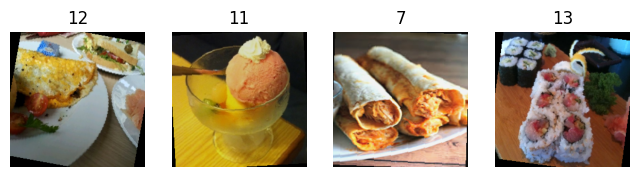

In [7]:
# parametri di normalizzazione usati nel preprocessamento
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denormalize(img):
    return img * std + mean

examples = iter(train_loader)
images, labels = next(examples)

plt.figure(figsize=(8,3))

for i in range(4):
    plt.subplot(1,4,i+1)
    img = denormalize(images[i])           # denormalizzo l’immagine
    img = img.permute(1, 2, 0).clamp(0,1) # canali per ultimi, clip valori tra 0 e 1
    plt.imshow(img)
    plt.title(str(labels[i].item()))
    plt.axis('off')

plt.show()